# Quantum Algorithms

Quantum computers can run algorithms that are not possible on a classical computer. In this notebook, you will learn how to:

* ...implement two quantum algorithms in qrisp,
* ...use qrisp to simulate the results,
* ...and execute them on an IQM quantum computer.

# Part 0: Setup

Set your Python Runtime environment to 2025.07 (in the top toolbar, Runtime -> Set Runtime Environment, and select 2025.07).

Install the appropriate packages for Python by running the following cell:

In [18]:
!pip install --upgrade pip

In [19]:
!pip install "iqm-client[qiskit] >= 32.1.1, < 33.0"
!pip install "qrisp[iqm]"

If you are prompted to restart your Colab session, do so once, run this cell again, and then hit "Cancel" if you are prompted to restart again.

# Part 1: Bernstein-Vazirani algorithm

The Bernstein-Vazirani algorithm is a quantum algorithm that solves the following problem:
> Given a hidden $n$-bit secret code $s$, and access to an oracle that computes the function $f(x) = s \cdot x$ (the dot product modulo 2), determine the secret code $s$ using as few queries to the oracle as possible.

$\newcommand{\ket}[1]{\left| #1 \right\rangle}$
In order to implement the Bernstein-Vazirani algorithm, we will follow these steps:
1. **Initialization**: Prepare an $n$-qubit register (the "guess" or "input" qubits) in the state $\ket{0}^{\otimes n}$ .
2. **Hadamard Transform**: Apply the Hadamard gate to all qubits to create a superposition of all possible input states.
3. **Oracle Implementation**: Implement the oracle that encodes the secret code $s$ using an "answer" or "ancilla" qubit. The ancilla needs to be initialized in the state $
\frac{1}{\sqrt{2}}\left(\ket{0}-\ket{1}\right)$.
4. **Final Hadamard Transform**: Apply the Hadamard gate again to the $n$-qubit register.
5. **Measurement**: Measure the $n$-qubit register to obtain the secret code $s$.

Let's start by importing the qrisp package (takes around 50s to load).

In [20]:
from qrisp import *

**Task 1: Fill in the code below to perform steps 1 and 2 in qrisp.**

In [21]:
# Step 1: Initialize a quantum variable
length_of_secret_code = 4
inputs = QuantumVariable(length_of_secret_code)# TODO: create the input quantum variables

# Step 2: Apply Hadamard gates to all qubits
h(inputs)
# TODO

<QuantumVariable 'inputs'>

Next up is the oracle.

An oracle is a black-box operation that encodes a function $f(x)$ into a quantum circuit. In the Bernstein-Vazirani algorithm, the oracle is designed to encode the secret code $s$ such that when it is applied to an input state $\ket{x}$, it produces a phase shift based on the dot product $s \cdot x$, that is, the number of bits where both $x$ and $s$ are `1` . Specifically, the oracle applies the transformation: $$U_f\ket{x} = (-1)^{s \cdot x}\ket{x}$$

For the Bernstein-Vazirani algorithm to be useful, you can't already know the secret code, which means that somebody else has to hand you the oracle. But in order to understand how this might work, you should try to make the oracle yourself!

**Task 2: Implement the Bernstein-Vazirani oracle that encodes the secret code $s$ using a controlled-X (CX) operation. Remember to use an "answer" or "ancilla" qubit (recommended: via an additional `QuantumVariable` inside the oracle function).**


In [22]:
## Implementation

def oracle(qubits, secret_code):
    # TODO
    ancilla = QuantumVariable(1)
    x(ancilla)
    h(ancilla)
    for i in range(length_of_secret_code):
        if secret_code[i] == '1':
            cx(qubits[i],ancilla)
    return qubits

# Step 3: Define a secret code and call the oracle
secret_code = '1101'
# TODO
oracle(inputs,secret_code)
# Step 4: Apply a final round of Hadamard gates

# TODO
h(inputs)
# Simulate the circuit
print(inputs)


{'1101': 1.0}                                                                        


If you want to see the circuit you have built so far, you can print it out using the `print` function:

In [23]:
print(inputs.qs)

QuantumCircuit:
---------------
           ┌───┐          ┌───┐          
 inputs.0: ┤ H ├───────■──┤ H ├──────────
           ├───┤       │  └───┘┌───┐     
 inputs.1: ┤ H ├───────┼────■──┤ H ├─────
           ├───┤┌───┐  │    │  └───┘     
 inputs.2: ┤ H ├┤ H ├──┼────┼────────────
           ├───┤└───┘  │    │       ┌───┐
 inputs.3: ┤ H ├───────┼────┼────■──┤ H ├
           ├───┤┌───┐┌─┴─┐┌─┴─┐┌─┴─┐└───┘
ancilla.0: ┤ X ├┤ H ├┤ X ├┤ X ├┤ X ├─────
           └───┘└───┘└───┘└───┘└───┘     
Live QuantumVariables:
----------------------
QuantumVariable inputs
QuantumVariable ancilla


Now, use the IQM backend to execute the circuit and measure the qubits to retrieve the secret code.

In [27]:
from qrisp.interface import IQMBackend
token = input("Please enter your IQM API token: ")
iqm_emerald = IQMBackend(api_token = token, device_instance = "sirius")

inputs.get_measurement(backend = iqm_emerald)

Please enter your IQM API token:  K5FqRbvM+Tu8rreMVvztE6Vz0XoaViSiBRC99mPeSaIBmt7X3qB9orRenn2hC9AE


{'1101': 0.816,
 '1100': 0.05,
 '0101': 0.043,
 '1001': 0.034,
 '1000': 0.021,
 '0000': 0.02,
 '1111': 0.006,
 '0001': 0.005,
 '0100': 0.004,
 '1011': 0.001}

# Part 2: Variational Quantum Algorithms: QAOA and MaxCut

In this section, you will...


*   ...solve the MaxCut problem with QAOA by using the `iqm.qaoa` package to use QAOA.
*   ...experiment with the built-in functions of `iqm.qaoa`.

Recall that the MaxCut problem is the following:

Suppose that you have $N$ students who are taking an exam. You must assign each student to take the exam in one of two rooms, which we will call room $0$ and room $1$. Students who are friends and in the same room are more likely to cheat. Your goal is to minimize the chance of cheating by separating as many pairs of friends as possible. Assume you know the friendships.

Before we start, install the iqm-qaoa package. (If you are prompted to restart your Colab session, you should be fine if you hit "Cancel.")

In [6]:
!pip install iqm-qaoa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 242.9 kB/s  0:00:05257.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 228.8 kB/s  0:00:059.0 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 269.4 kB/s  0:00:34a 0:00:010:00:02:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 544.4 kB/s  0:00:048.8 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.5/936.5 kB 968.0 kB/s  0:00:01932.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 627.2 kB/s  0:00:04632.9 kB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 291.2 kB/s  0:00:43a 0:00:010:00:02:05
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15/15 [iqm-qaoa] 14/15 [iqm-qaoa]xpy]


### Setting up the problem

We start by assigning each student a variable $x_i$ which is equal to $0$ if they are assigned to room $0$ and $1$ if they are in room $1$.

The cost function encodes the friendships. In lecture, we wrote it as
$$H\left( \lbrace Z_i \rbrace \right) = \sum_{i < j} J_{ij}Z_i Z_j$$
where $J_{ij}$ is 1 if students $i$ and $j$ are friends and 0 if not, and $Z_i$ is $-1$ if student $i$ is assigned to room $0$ and $Z_i$ is $+1$ if student $i$ is assigned to room $1$.

Unfortunately, the software requires us to write this in terms of $x_i$, which can be 0 or 1, instead of $Z_i$. A little straightforward math shows us that $Z_i = 1-2x_i$, which means that we can rewrite the cost function as
$$H\left( \lbrace x_i \rbrace \right) = \sum_{i < j} J_{ij}(1-2x_i)(1-2x_j)$$

We need to feed this cost function to QAOA. Let's first write down $J_{ij}$, which is just a matrix.

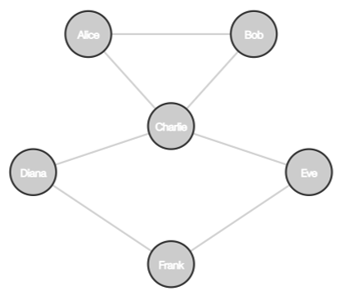

**Task: For the friendship graph above ([which you played with in lecture here](https://www.iqmacademy.com/explore/maxcut/)), fill in the matrix below.**

In [7]:
num_students = 6
Jij = [[0, 1, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0]]
       # TO DO: Fill in the question marks
       #We set everything in the bottom left to 0 to avoid double-counting every friendship, although this won't have an effect in the end

Next we need to create the object representing the MaxCut problem and the cost function. This is done using the `dimod` module, which has handy tools for creating functions of binary variables.

**Task: Implement the cost function in the code below.**


In [8]:
from dimod import Binary, ConstrainedQuadraticModel, quicksum

# Create the variables. This is just a list of variables where x[i] represents the variable xi.
xi = {i: Binary(i) for i in range(num_students)}

# Define the cost function. As written here, quicksum implements the sum over i and j.
cost = quicksum(
    # TODO: Implement the cost function
    Jij[i][j]*(1-2*xi[i])*(1-2*xi[j])
    for i in range(num_students)
    for j in range(num_students)
    )


Once the cost function is defined, we can use it to create a `ConstrainedQuadraticInstance` object, which the QAOA package can work with.

In [9]:
# Create a problem which can be passed into the QAOA algorithm
MaxCut_QUBO = ConstrainedQuadraticModel()

# Set the cost function of the problem
MaxCut_QUBO.set_objective(cost)

# Now create the problem
from iqm.applications.qubo import ConstrainedQuadraticInstance

MaxCut_instance = ConstrainedQuadraticInstance(MaxCut_QUBO)

### Connecting to Resonance

It turns out that for special classes of problems, including this one, there are efficient classical ways to optimize the ansatz. Why, then, do we need the quantum computer at all? The thing is still difficult classically is to take the state with its optimized parameters and find the probabilities of getting all of the possible output measurements. Ideally, the most probable output is the correct answer.

To do this, we're going to connect to Resonance.

This will look a little different from what we've done before in order to work with the QAOA interface. We'll then set up a `SamplerResonance` object, which tells the QAOA algorithm to use the quantum computer to find the probabilities of all the outputs.

In [12]:
API_TOKEN = input("Please enter your Resonance API token.")
iqm_url = "https://cocos.resonance.meetiqm.com/garnet" # You can change Emerald to Garnet or Sirius if you'd like or if the queue is long.

from iqm.qaoa.backends import SamplerResonance

# Create sampler object
sampler = SamplerResonance(token=API_TOKEN, server_url=iqm_url , transpiler="Default")

## If you want to use a simulator instead of the quantum computer, you can uncomment this code:
# from iqm.qaoa.backends import SamplerSimulation
# sampler = SamplerSimulation()

Please enter your Resonance API token. K5FqRbvM+Tu8rreMVvztE6Vz0XoaViSiBRC99mPeSaIBmt7X3qB9orRenn2hC9AE


### Running QAOA
We now create the QUBO QAOA instance from the problem instance and train it (run the optimization loop to find find optimal variational parameters).

The `train` method has several possible parameters. By default, it uses uses analytical formulas if the QAOA has one layer and a simulator otherwise.

Recall that the $i$th layer of the QAOA ansatz applies the circuit
$$e^{-i\beta_i H_{mix}}e^{-i \gamma_i H_c}$$
to the qubits, where the variational parameters are $\beta_i$ and $\gamma_i$. So, the number of variational parameters in QAOA is twice the number of layers.

In [13]:
from iqm.qaoa.qubo_qaoa import QUBOQAOA

MaxCut_qaoa = QUBOQAOA(problem=MaxCut_instance, num_layers=1, # TODO: choose a number of layers; play around with this!
                       initial_angles=[0.1,0.2]) # TODO: Input a list of initial guesses for the gamma_i and beta_i (all as one list). To start off, guess randomly; you can see how different initial guesses behave.
MaxCut_qaoa.train()

Finally, we can sample the resulting state using the quantum computer (if you kept the sampler as the quantum computer above).



In [14]:
samples = MaxCut_qaoa.sample(sampler=sampler, shots=20_000)
print(samples)

# Find the most probable outcome
most_probable = max(samples, key=lambda y: samples[y])

# Find the cost of the most probable outcome
most_probable_cost = MaxCut_instance.quality(most_probable)

print("Cost of most probable coutcome: ", most_probable_cost)
print("Most probable outcome :", most_probable)

{'110010': 308, '010100': 389, '101001': 1271, '011010': 446, '011100': 495, '101000': 384, '101010': 428, '010110': 1085, '101110': 143, '011001': 1318, '001001': 1102, '110110': 889, '110100': 430, '101101': 171, '010111': 147, '001111': 65, '100111': 157, '001000': 476, '010010': 263, '001110': 341, '001101': 177, '100001': 260, '001100': 556, '100011': 338, '110011': 286, '100110': 1144, '001010': 554, '101100': 445, '010101': 389, '110001': 541, '110111': 114, '100010': 312, '011011': 157, '001011': 211, '000110': 189, '010011': 324, '110101': 348, '000011': 71, '100101': 394, '101011': 189, '000101': 69, '100100': 374, '011110': 141, '010001': 247, '011000': 461, '000001': 155, '000100': 77, '011101': 132, '111101': 46, '111010': 46, '111110': 130, '011111': 44, '000000': 82, '111001': 115, '000010': 81, '010000': 83, '111100': 51, '101111': 60, '110000': 80, '111011': 42, '111000': 35, '000111': 40, '111111': 33, '100000': 69}
Cost of most probable coutcome:  -12.0
Most probable

**Task: Interpret the output you get. How did the algorithm assign rooms to the students? Does it match the optimal result we found in lecture?**

We can also calculate the cost of different outputs and compare them with the optimal cost, which is calculated by classical brute force.

In [15]:
print("Optimal cost: ", MaxCut_instance.lower_bound) #Classically obtain the best possible cost by brute force

# Calculate the cost function of all found solutions
samples_cost = {sample: MaxCut_instance.quality(sample) for sample in samples}

# Find the sample with the best quality
best_sample = min(samples_cost, key=lambda y: samples_cost[y])

# Find the best quality
best_quality = samples_cost[best_sample]

print("Best sample found by QAOA: ", best_sample)
print("Best cost found by QAOA: ", best_quality)

Optimal cost:  -12.0
Best sample found by QAOA:  101001
Best cost found by QAOA:  -12.0


### Using some built-in MaxCut functionality

The IQM QAOA package has a lot of functionality that automates creating and solving MaxCut problems. It can generate random instances of MaxCut using `maxcut_generator`, solve them classically, and solve them with QAOA for comparison. Below is a code snippet for this.

**Task: Finish the code snippet. Play around with it!**

Optimal cost:  -32.0


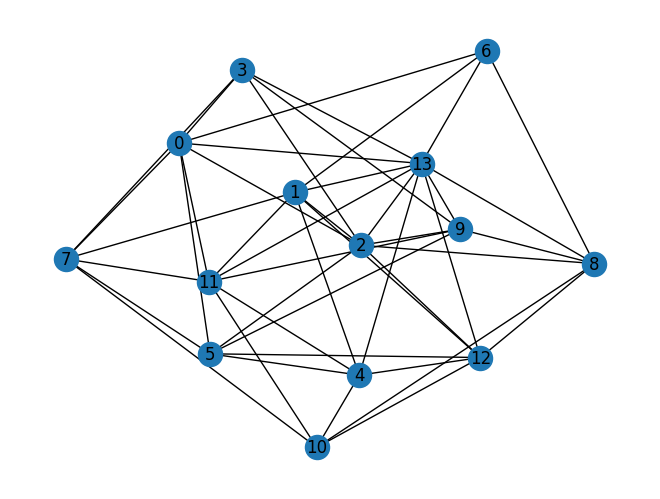

In [16]:
from iqm.applications.maxcut import maxcut_generator

problem_size=14 # Number of nodes (students) in the graph. Some of the later code will be slow if this is above 30 or so.

# The next line returns a MaxCut problem which can be used just like our previous ConstrainedQuadraticInstance
random_MaxCut = next(maxcut_generator(n=problem_size, n_instances=1))

# Draw the graph
import networkx as nx
nx.draw(random_MaxCut.qubo_graph,with_labels=True)

# Classically obtain the best possible cost by brute force
print("Optimal cost: ", random_MaxCut.lower_bound)

# TODO: Adapt the earlier code to run QAOA on the randomly generated graph above. How well did QAOA do?

# Homework: Grover's algorithm

Grover's algorithm is a quantum algorithm that solves the following problem:
> Given a function $f:\{0,1\}^n \rightarrow \{0,1\}$ that outputs 1 for a single input $x_0$ (the "marked" item) and 0 for all other inputs, find the marked item $x_0$ using as few queries to the function as possible.

In the context below, we'll use 0 to represent "false" and 1 to represent "true."

Our goal is to implement Grover's algorithm to find the input that satisfies the following Boolean formula (a "SAT problem"):
$$ (x_0 \text{ OR } x_1) \text{ AND } (\neg x_0 \text{ OR } x_1)  \text{ AND } (x_0 \text{ OR } \neg x_1)$$

Remember that $\neg x_1$ means NOT $x_1$. $\neg x_1$ is true when $x_1$ is false.

Each piece in parentheses is called a "clause", and each variable (either $x_i$ or $\neg x_i$) inside the clause is called a "literal."

We represent the possible solutions (possible true/false values for $x_0$ and $x_1$) with 2 "register" qubits, where $\ket{00}$ represents both variables being false, $\ket{10}$ represents $x_0$ true and $x_1$ false, and so on.

Grover's algorithm consists of the following steps:

1.    **Intialization:**   Prepare two register qubits, one ancilla per clause, and one extra ancilla. The final ancilla should be prepared in the state $\ket{-}$, and the rest in state $\ket{0}$.
2.   **Apply Hadamards**: Apply a Hadamard gate to every register qubit, which gives us quantum parallelism (i.e., means we're inputting a superposition of all possible solutions)
3.   **Oracle Implementation**: Apply the oracle, which "tags" the correct solution by flipping the sign of its amplitude
4.   **Diffusion Operator**: Apply the "diffusion operator", which increases the probability of measuring the tagged state
5.   **Repeat**: Repeat steps 3 and 4 until another repeat would instead decrease the probability of measuring the tagged state.
6.   **Measure Register Qubits**: The most probable measurement outcome is the solution.


## Task: Implement Grover's algorithm

**Step 1: Initialize a quantum variable and Hadamard transform all but the ancillary qubits.**

In [1]:
from qrisp import *

## Create a quantum variable with two qubits, representing x0 and x1, and one for the ancillary qubits (one qubit per clause and one additional ancilla)
qv = QuantumVariable(2)
ancillas = QuantumVariable(4)
## Step 1: Apply single-qubit Hadamard gates to the non-ancilla qubits
# TODO
for i in range(2):
    h(qv[i])
## Visualize the circuit
print(qv.qs)
print(ancillas.qs)

QuantumCircuit:
---------------
      ┌───┐
qv.0: ┤ H ├
      ├───┤
qv.1: ┤ H ├
      └───┘
Live QuantumVariables:
----------------------
QuantumVariable qv
QuantumCircuit:
---------------
ancillas.0: 
            
ancillas.1: 
            
ancillas.2: 
            
ancillas.3: 
            
Live QuantumVariables:
----------------------
QuantumVariable ancillas


In [2]:
# Prepare the final ancilla in the |-⟩ state
# TODO
x(ancillas[3])
h(ancillas[3])
print(ancillas.qs)

QuantumCircuit:
---------------
ancillas.0: ──────────
                      
ancillas.1: ──────────
                      
ancillas.2: ──────────
            ┌───┐┌───┐
ancillas.3: ┤ X ├┤ H ├
            └───┘└───┘
Live QuantumVariables:
----------------------
QuantumVariable ancillas


**Step 2: Define the oracle.**

 An oracle is a black-box operation that encodes a function $f(x)$ into a quantum circuit. In Grover's algorithm, the oracle is designed to mark the solution state by flipping its amplitude. Specifically, the oracle applies the transformation: $$U_f\ket{x} = (-1)^{f(x)}\ket{x}$$ where $f(x) = 1$ for the marked item and $f(x) = 0$ for all other items.

 We'll design our oracle in the following way. Ancilla $i$ should be set to $1$ if clause $i$ is false. Then we flip the final ancilla (which gives us the desired minus sign) if all of the ancillas are $0$ (that is, if all of the clauses are true).

In [3]:
# Define the oracle
def apply_oracle(q, ancillas):
# --- ORACLE IMPLEMENTATION ---

# Clause ancillas: ancillas[0], ancillas[1], ancillas[2]
# Final ancilla for phase kickback: phase_ancilla

# --------------------------------------------------------
# Clause 1: (x0 OR x1) is FALSE only when x0=0 AND x1=0
# --------------------------------------------------------
    x(qv[0])
    x(qv[1])
    mcx([qv[0], qv[1]], ancillas[0])
    x(qv[0])
    x(qv[1])
    
    # --------------------------------------------------------
    # Clause 2: (NOT x0 OR x1) is FALSE only when x0=1 AND x1=0
    # --------------------------------------------------------
    x(qv[1])
    mcx([qv[0], qv[1]], ancillas[1])
    x(qv[1])
    
    # --------------------------------------------------------
    # Clause 3: (x0 OR NOT x1) is FALSE only when x0=0 AND x1=1
    # --------------------------------------------------------
    x(qv[0])
    mcx([qv[0], qv[1]], ancillas[2])
    x(qv[0])
    
    # --------------------------------------------------------
    # If all 3 clause ancillas are 0 → all clauses TRUE
    # Apply multi-controlled NOT on phase ancilla
    # (Since phase ancilla = |−>, this creates a phase flip)
    # --------------------------------------------------------
    
    # We need ancillas in state |0 0 0| → detect this with X gates:
    x(ancillas[0])
    x(ancillas[1])
    x(ancillas[2])
    
    mcx([ancillas[0], ancillas[1], ancillas[2]], ancillas[3])
    
    # Restore ancillas:
    x(ancillas[0])
    x(ancillas[1])
    x(ancillas[2])
    
    # --------------------------------------------------------
    # UNCOMPUTE CLAUSE ANSILLAS (run clause logic in reverse)
    # --------------------------------------------------------
    
    # Uncompute clause 3
    x(qv[0])
    mcx([qv[0], qv[1]], ancillas[2])
    x(qv[0])
    
    # Uncompute clause 2
    x(qv[1])
    mcx([qv[0], qv[1]], ancillas[1])
    x(qv[1])
    
    # Uncompute clause 1
    x(qv[0])
    x(qv[1])
    mcx([qv[0], qv[1]], ancillas[0])
    x(qv[0])
    x(qv[1])
    

**Step 3: Define the diffusion operator**

The diffusion operator has the effect of "mirroring" the amplitudes with respect to the average. In particular, it turns the state
$$\ket{\psi}=\sum_x a_x \ket{x}$$
into the state
$$\ket{\psi}=\sum_x (2\overline{a}-a_x)\ket{x}$$
where $\overline{a}$ is the average of all of the $a_x$.

The effect of this operator in the context of Grover's algorithm is to enhance the probability of the "tagged" state, which is the only state $\ket{x}$ with a negative amplitude $a_x$.

One can mathematically prove that the operator we want is exactly the same as the following: apply Hadamard gates to all of the registers. Then apply an oracle that tags the state where all of the qubits are $0$. Finally, apply Hadamard gates to all of the registers again.

In [4]:
# Define the diffusion operator
def apply_diffusion(q, ancillas):
    # H to computational basis: H|ψ> → amplitudes visible as |00>, |01>, etc.
    h(qv[0])
    h(qv[1])
    # Phase flip |00> = H^{-1}|s> (since H|00> = |s>)
    x(q[0])  # |00> → |11>
    x(q[1])
    mcx([q[0], q[1]], ancillas[3])  # Flip phase of |00> state
    x(q[0])  # Restore
    x(q[1])
    
    h(q[0])  # H back to superposition basis
    h(q[1])

**Step 4: Run the algorithm**

With both components defined, we can construct the full Grover's algorithm circuit by alternating between the oracle and diffusion operator for a specified number of iterations. Finally, we measure the qubits to obtain the result, which should yield the marked item with high probability.

In [7]:
# Number of iterations for Grover's algorithm
iterations = 2 #experiment with the number of iterations to find the optimal number

# Apply the oracle and the diffusion operator for the required number of iterations
for _ in range(iterations):
    # TODO: fill in this loop
    apply_oracle(qv,ancillas)
    apply_diffusion(qv,ancillas)
# Output the quantum circuit
print(qv.qs)
print(qv.get_measurement())

QuantumCircuit:
---------------
            ┌───┐┌───┐     ┌───┐          ┌───┐     ┌───┐┌───┐          ┌───┐»
      qv.0: ┤ H ├┤ X ├──■──┤ X ├───────■──┤ X ├──■──┤ X ├┤ X ├───────■──┤ X ├»
            ├───┤├───┤  │  ├───┤┌───┐  │  ├───┤  │  └───┘└───┘       │  ├───┤»
      qv.1: ┤ H ├┤ X ├──■──┤ X ├┤ X ├──■──┤ X ├──■───────────────────■──┤ X ├»
            └───┘└───┘┌─┴─┐├───┤└───┘  │  └───┘  │            ┌───┐  │  └───┘»
ancillas.0: ──────────┤ X ├┤ X ├───────┼─────────┼─────────■──┤ X ├──┼───────»
                      └───┘└───┘     ┌─┴─┐┌───┐  │         │  ├───┤  │       »
ancillas.1: ─────────────────────────┤ X ├┤ X ├──┼─────────■──┤ X ├──┼───────»
                                     └───┘└───┘┌─┴─┐┌───┐  │  ├───┤┌─┴─┐     »
ancillas.2: ───────────────────────────────────┤ X ├┤ X ├──■──┤ X ├┤ X ├─────»
            ┌───┐┌───┐                         └───┘└───┘┌─┴─┐└───┘└───┘     »
ancillas.3: ┤ X ├┤ H ├───────────────────────────────────┤ X ├───────────────»
            └───┘└──

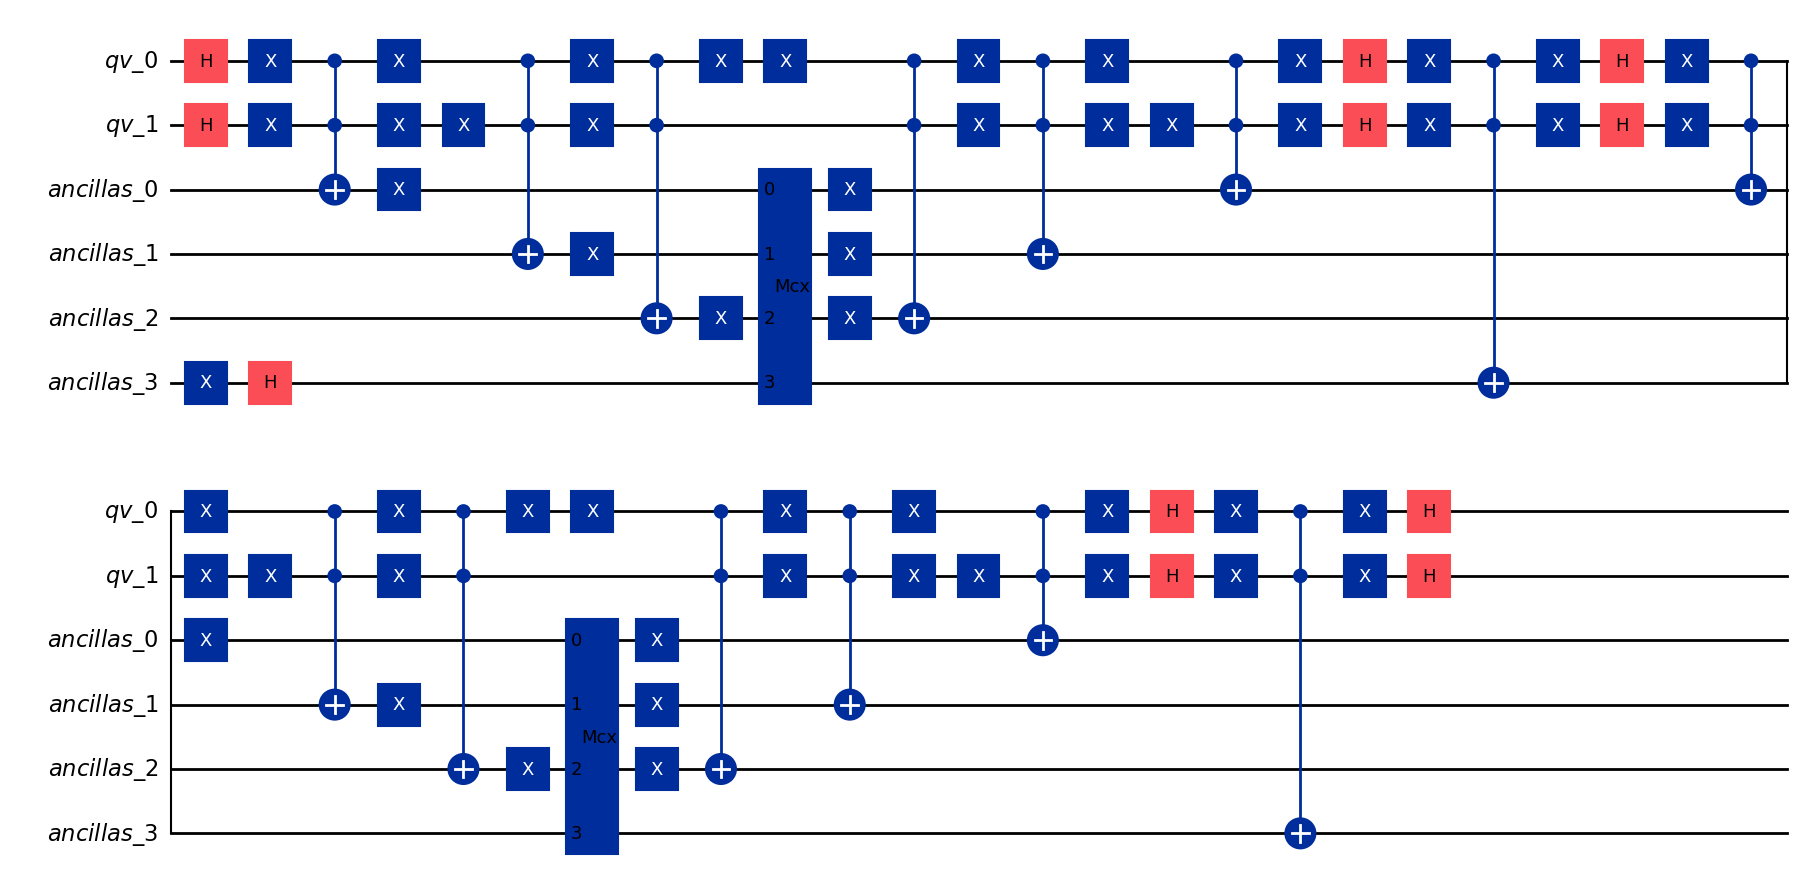

In [6]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
qasm_str = qv.qs.to_qasm2()
qc = QuantumCircuit.from_qasm_str(qasm_str)
circuit_drawer(qc,output="mpl")

Now, use the IQM backend to execute the circuit and measure the qubits to retrieve the marked item.

In [55]:
from qrisp.interface import IQMBackend
token = input("Please enter your IQM API token: ")
iqm_emerald = IQMBackend(api_token = token, device_instance = "garnet")

Please enter your IQM API token:  LAH8ZT3ryLKuUa/gvx2tva84JW9Xd1vE2Zb+dyz/KukBmuipAKdx84dxXS3R+oAL


In [56]:
print(qv.get_measurement(backend = iqm_emerald))

{'10': 0.293, '00': 0.26, '01': 0.236, '11': 0.211}



**Task: Repeat the experiment with a different SAT formula (make a new oracle!) and check the results.**

### Using the qrisp Grover library

qrisp comes equipped with a Grover's algorithm library that simplifies the implementation process. You can use the `grover_alg` function to create a Grover's search circuit with minimal effort. `tag_state` allows you to specify the state you want to search for easily, so the oracle becomes a one-liner.

The code below shows how to use qrisp's built-in functions to implement Grover's algorithm. Read through, understand the code, and run it!

In [57]:
from qrisp.grover import tag_state, grovers_alg

# Define the oracle
# This oracle tags the state |2> by changing its phase by pi.
def oracle(qv, phase = np.pi):
    tag_state({qv : 2}, phase = phase)

# Define the QuantumFloat representing the search space
n = 3
qf = QuantumFloat(n)

# Execute Grover's algorithm
grovers_alg(qf,
            oracle,
            exact = True,
            winner_state_amount = 1)

# Retrieve the measurements
simulator_res = qf.get_measurement()
print("Simulator result: ", simulator_res)

meas_res = qf.get_measurement(backend = iqm_emerald)
print("Emerald result: ", meas_res)


Simulator result:  {2: 1.0}                                                          
Emerald result:  {2: 0.458, 0: 0.109, 1: 0.094, 6: 0.085, 5: 0.068, 4: 0.067, 3: 0.063, 7: 0.056}


In [ ]:

# Copyright 2025 IQM Quantum Computers (Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.